In [7]:
import matplotlib.pyplot as plt
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
import numpy as np
import pandas as pd
import os

from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.linear_model import LogisticRegressionCV  ## logistic regression
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.svm import SVC  ## SVM

from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

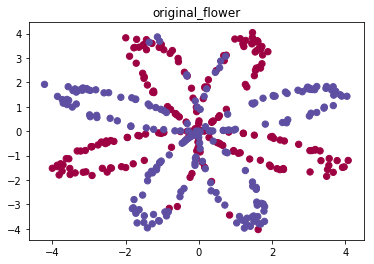

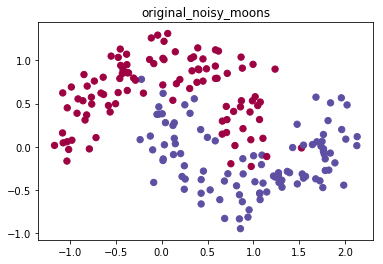

In [2]:
# First Dataset
datas = []
X, Y = load_planar_dataset()
name = 'flower'
X = X.T
Y = Y[0]
datas.append((name, X, Y))

# Second Dataset
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
datas.append(("noisy_moons", noisy_moons[0], noisy_moons[1]))

# Visualize
for name, X, Y in datas:
    plt.scatter(X[:, 0], X[:, 1], c=Y , s=40, cmap=plt.cm.Spectral);
    plt.title(name+'_original')
    plt.title('original_' + name)
    plt.savefig(os.path.join('pic', 'original_' + name))
    plt.show()

# K Nearest Neighbor(KNN)

Accuracy 86.0%


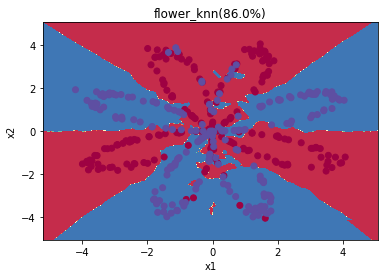

Accuracy 94.5%


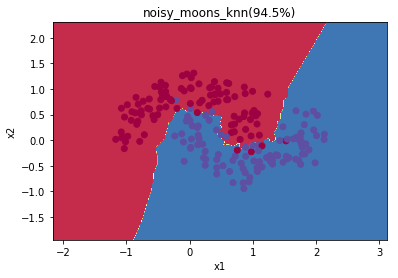

In [3]:
for name, X, Y in datas:
    clf = KNeighborsClassifier(n_neighbors=6)  ## 設定用最近的3個鄰居投票
    clf.fit(X, Y)  ## 訓練模型

    y_pred = clf.predict(X)  ## 預測模型
    print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")  ## 計算精準度
    
    plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)  ## 視覺化分類器的分類結果
    plt.title(name+'_knn(' + str((Y == y_pred).sum()/ X.shape[0]*100)+"%)")
#     plt.savefig(os.path.join('pic', name+'_knn'))  ## 儲存圖片
    plt.show()

# Logistic Regression

Accuracy 47.0%


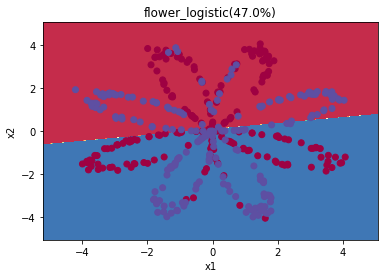

Accuracy 87.0%


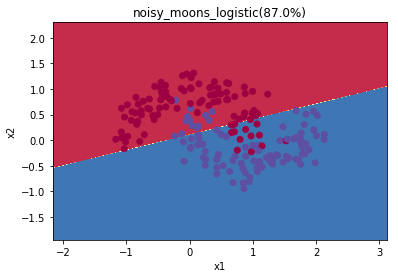

In [4]:
for name, X, Y in datas:
    clf = LogisticRegressionCV()
    clf.fit(X, Y)
    
    y_pred = clf.predict(X)
    print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")
    
    plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
    plt.title(name+'_logistic(' + str((Y == y_pred).sum()/ X.shape[0]*100)+"%)")
#     plt.savefig(os.path.join('pic', name+'_logistic'))
    plt.show()


# Decision Tree

Accuracy 100.0%


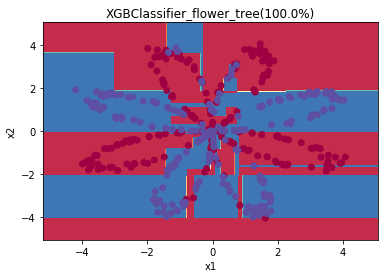

Accuracy 100.0%


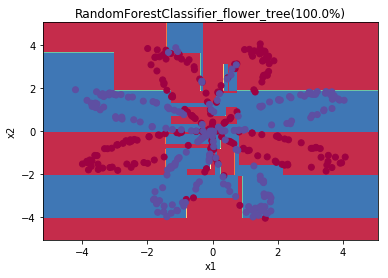

Accuracy 100.0%


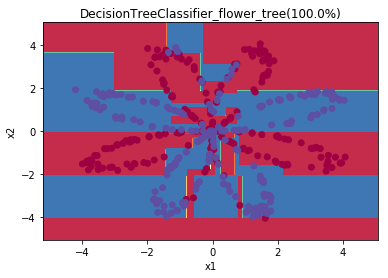

Accuracy 100.0%


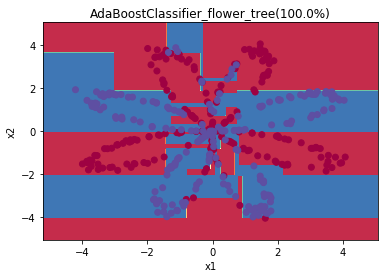

Accuracy 100.0%


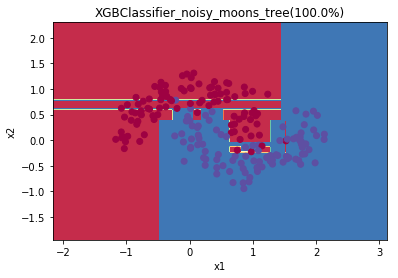

Accuracy 100.0%


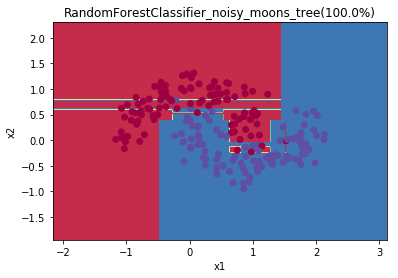

Accuracy 100.0%


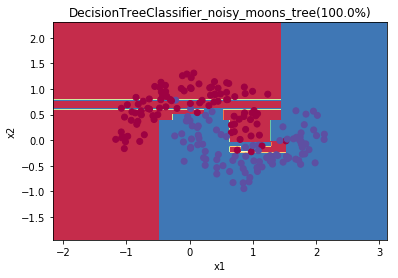

Accuracy 100.0%


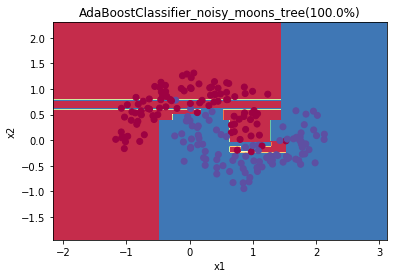

In [10]:
clfs={
"DecisionTreeClassifier":DecisionTreeClassifier,
"RandomForestClassifier":RandomForestClassifier,
"AdaBoostClassifier":AdaBoostClassifier,
"XGBClassifier":XGBClassifier
}
for name, X, Y in datas:
    for clf_name, clf in clfs.items():
        clf = DecisionTreeClassifier()

        clf.fit(X, Y)

        y_pred = clf.predict(X)
        print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")

        plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
        plt.title(clf_name + "_" + name +'_tree(' + str((Y == y_pred).sum()/ X.shape[0]*100)+"%)")
        plt.savefig(os.path.join('pic', clf_name + "_" + name+'_tree'))
        plt.show()

# Suport Vector Machine(SVM)

Accuracy 47.5%


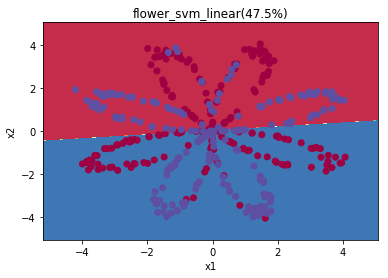

Accuracy 79.5%


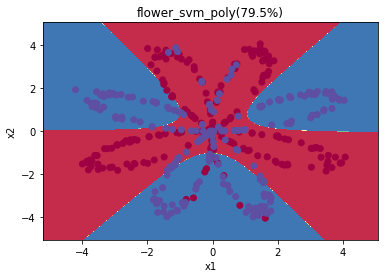

Accuracy 84.0%


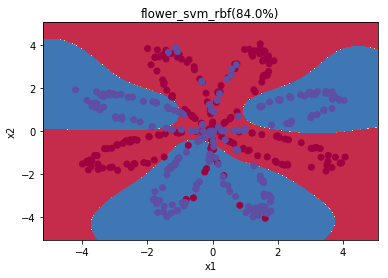

Accuracy 34.25%


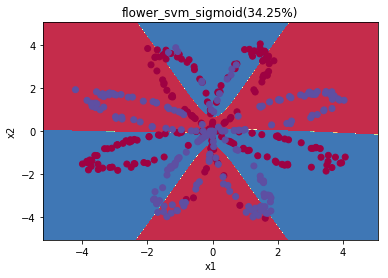

Accuracy 86.0%


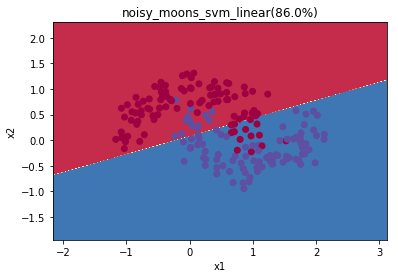

Accuracy 80.5%


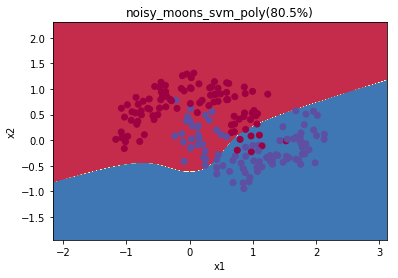

Accuracy 92.5%


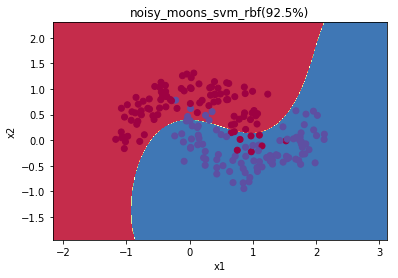

Accuracy 77.0%


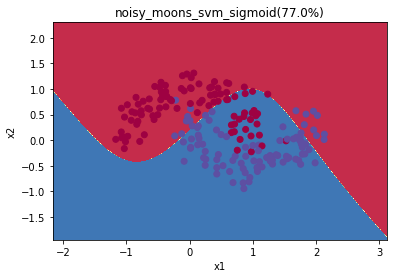

In [10]:
kernels =['linear', 'poly', 'rbf', 'sigmoid']  ## 選擇kernel
for name, X, Y in datas:
    for k in kernels:
        clf = SVC(C=1.0, kernel=k)  ## 這邊大家可以調整懲罰項C試試看
        clf.fit(X, Y)

        y_pred = clf.predict(X)
        print('Accuracy',  str((Y == y_pred).sum()/ X.shape[0]*100)+"%")

        plot_decision_boundary(lambda x: clf.predict(x), X.T, Y)
        plt.title(name+'_svm_'+ k +'(' + str((Y == y_pred).sum()/ X.shape[0]*100)+"%)")
        plt.savefig(os.path.join('pic', name+'_svm_'+ k))
        plt.show()

# XGB + CV

In [124]:
import math
import string
import re

from sklearn.cross_validation import train_test_split
import xgboost

In [89]:
def preprocess(df):
    avg_age = df['Age'].median()

    def agecat(age):
        if age <= 16:
            cat = 0
        elif age > 16 and age <= 32:
            cat = 1
        elif age > 32 and age <= 48:
            cat = 2
        elif age < 48 and age <= 64:
            cat = 3
        else:
            cat = 4
        return cat
    
    def farecat(f):
        if f <= 16:
            cat = 0
        elif f > 17 and f <= 32:
            cat = 1
        elif f > 32 and f <= 48:
            cat = 2
        elif f < 48 and f <= 64:
            cat = 3
        elif f < 64 and f <= 80:
            cat = 4
        elif f < 80 and f <= 96:
            cat = 5
        else:
            cat = 6
        return cat
    
    # avg_fare
    fares_notnull = df[pd.notnull(df['Fare'])]['Fare']
    avg_fare = fares_notnull.median()

    # ticket
    ticket_cat = {}
    for ticket in df['Ticket']:
        if ticket.isdigit():
            ticket_cat[ticket] = 1
        elif ticket.startswith('A'):
            ticket_cat[ticket] = 2
        elif ticket.startswith('C'):
            ticket_cat[ticket] = 3
        elif ticket.startswith('F'):
            ticket_cat[ticket] = 4
        elif ticket.startswith('P'):
            ticket_cat[ticket] = 5
        elif ticket.startswith('SOTON'):
            ticket_cat[ticket] = 6
        elif ticket.startswith('STON'):
            ticket_cat[ticket] = 7
        elif ticket.startswith('S'):
            ticket_cat[ticket] = 8
        elif ticket.startswith('W'):
            ticket_cat[ticket] = 9
        else:
            ticket_cat[ticket] = 0
            
    ticket_cat1 = {}
    for num, name in enumerate(list(set([item.split()[0].replace(".", "").replace("/", "") for item in df['Ticket'] if not item.isdigit()]))):
        ticket_cat1[name] = num
    
    # cabin
    cabin_cat = {}
    for cabin in df['Cabin']:
        if pd.isnull(cabin):
            cabin_cat[cabin] = 0
        elif cabin.startswith('A'):
            cabin_cat[cabin] = 1
        elif cabin.startswith('B'):
            cabin_cat[cabin] = 2
        elif cabin.startswith('C'):
            cabin_cat[cabin] = 3
        elif cabin.startswith('D'):
            cabin_cat[cabin] = 4
        elif cabin.startswith('E'):
            cabin_cat[cabin] = 5
        else:
            cabin_cat[cabin] = 0
    
    # embarked
    embarked_cat = {}
    for embarked in df['Embarked']:
        if pd.isnull(embarked):
            embarked_cat[embarked] = 0
        elif embarked.startswith('S'):
            embarked_cat[embarked] = 0
        elif embarked.startswith('Q'):
            embarked_cat[embarked] = 1
        elif embarked.startswith('C'):
            embarked_cat[embarked] = 2
            
    # title
    title_mapping= {
        'Ms':"Miss",
        'Mlle':"Miss",
        'Miss':"Miss",
        'Mrs':"Mrs",
        'Mme':"Mrs",
        'MrsMartin(ElizabethL':"Mrs",
        'Mr':"Mr"
        }
    
    title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    # Name_with specail chars
    def withspecailchar(name):
        for char in name:
            if char in string.punctuation:
                return 1
        return 0
    
    def applyfun(row):
        row['Has_Cabin'] = 0 if pd.isnull(row['Cabin']) else 1
        row['Cabin'] = cabin_cat.get(row['Cabin'])
        row['Age'] = row['Age'] if pd.notnull(row['Age']) else avg_age
        row['Age_Cat'] = agecat(row['Age'])
        row['Fare'] = row['Fare'] if pd.notnull(row['Fare']) else avg_fare
        row['Fare_log2'] = math.log(row['Fare'], 2) if  row['Fare'] != 0 else 0
        row['Fare_Cat'] = farecat(row['Fare'])
        row['Ticket'] = ticket_cat.get(row['Ticket'])
        processed_ticket = row['Ticket'].split()[0].replace(".", "").replace("/", "") if not str(row['Ticket']).isdigit() else None
        row['Embarked'] = embarked_cat.get(row['Embarked'])
        row['Sex'] = 1 if row['Sex'] == 'male' else 0
        row['Name_Length'] = len(row['Name'])
        row['Name_With_Special_Char'] = withspecailchar(row['Name'].replace(',', "").replace('.', ""))
        row['Family_Size'] = row['SibSp'] + row['Parch']
        call = re.search(r'\,.+\.', row['Name']).group(0).replace(",", "").replace(".", "").replace(" ", "")
        call_cat = title_cat.get(title_mapping.get(call, "Rare"))
        row['Title'] = call_cat
        return row
    
    df = df.apply(applyfun, axis=1)
    df.drop('Name', axis=1, inplace=True)
    df.drop('Fare', axis=1, inplace=True)

    return df

In [107]:
df = pd.read_csv('train.csv')
df = preprocess(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Has_Cabin,Age_Cat,Fare_log2,Fare_Cat,Name_Length,Name_With_Special_Char,Family_Size,Title
0,1,0,3,1,22.0,1,0,2,0,0,0,1,2.857981,0,23,0,1,1
1,2,1,1,0,38.0,1,0,5,3,2,1,2,6.155492,5,51,1,1,3
2,3,1,3,0,26.0,0,0,7,0,0,0,1,2.986411,0,22,0,0,2
3,4,1,1,0,35.0,1,0,1,3,0,1,2,5.730640,4,44,1,1,3
4,5,0,3,1,35.0,0,0,1,0,0,0,2,3.008989,0,24,0,0,1


In [91]:
X = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat', 'Fare_log2',
       'Fare_Cat', 'Name_Length', 'Name_With_Special_Char', 'Family_Size',
       'Title']].values
Y = df['Survived'].values

In [99]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size =0.5)  ## 一般如果測試資料集超過1000筆就可以了，所以比率不會設這麼高
print(X_train.shape)  ## (445, 17)
print(X_valid.shape)  ## (446, 17) 
print(Y_train.shape)  ## (445,)
print(Y_valid.shape)  ## (446,)

(445, 17)
(446, 17)
(445,)
(446,)


In [125]:
def get_accuracy(clf):
    clf = clf()
    clf = clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    return (str(sum(Y_valid == y_pred)/Y_valid.shape[0]))

print('SVM: ', get_accuracy(SVC))
print('DecisionTree: ', get_accuracy(DecisionTreeClassifier))
print('RandomForest: ', get_accuracy(RandomForestClassifier))
print('AdaBoost: ', get_accuracy(AdaBoostClassifier))  ## Boosting的演算法
print('XGB: ', get_accuracy(XGBClassifier))

# SVM:  0.609865470852
# DecisionTree:  0.764573991031
# RandomForest:  0.795964125561
# AdaBoost:  0.784753363229
# XGB:  0.80269058296

SVM:  0.609865470852
DecisionTree:  0.757847533632
RandomForest:  0.804932735426
AdaBoost:  0.784753363229
XGB:  0.80269058296


In [121]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
params['max_depth'] = 3
params['learning_rate'] = 0.01

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 100, watchlist, early_stopping_rounds=100, verbose_eval=10)
y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy: ", str(sum(Y_valid == (y_pred > 0.5))/Y_valid.shape[0]))

# # [0]	train-logloss:0.687884	valid-logloss:0.6885
# # Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

# # Will train until valid-logloss hasn't improved in 100 rounds.
# # [10]	train-logloss:0.640351	valid-logloss:0.646802
# # [20]	train-logloss:0.600589	valid-logloss:0.612317
# # [30]	train-logloss:0.566967	valid-logloss:0.583539
# # [40]	train-logloss:0.538181	valid-logloss:0.559665
# # [50]	train-logloss:0.513437	valid-logloss:0.53965
# # [60]	train-logloss:0.492055	valid-logloss:0.522721
# # [70]	train-logloss:0.473494	valid-logloss:0.508487
# # [80]	train-logloss:0.457333	valid-logloss:0.496546
# # [90]	train-logloss:0.443178	valid-logloss:0.48698
# # Accuracy:  0.813901345291

[0]	train-logloss:0.687884	valid-logloss:0.6885
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.640351	valid-logloss:0.646802
[20]	train-logloss:0.600589	valid-logloss:0.612317
[30]	train-logloss:0.566967	valid-logloss:0.583539
[40]	train-logloss:0.538181	valid-logloss:0.559665
[50]	train-logloss:0.513437	valid-logloss:0.53965
[60]	train-logloss:0.492055	valid-logloss:0.522721
[70]	train-logloss:0.473494	valid-logloss:0.508487
[80]	train-logloss:0.457333	valid-logloss:0.496546
[90]	train-logloss:0.443178	valid-logloss:0.48698
Accuracy:  0.813901345291
